# Проект

## Поиск и выбор набора данных для построения моделей машинного обучения. На основе выбранного набора данных студент должен построить модели машинного обучения для решения *или* задачи классификации, *или* задачи регрессии.

В рамках этого проекта будет решаться __задача классификации__ того, является ли пойманное насекомое переносчиком вируса Западного Нила (*West Nile virus, WNV*) на основе данных с *Kaggle.com*, открытой платформы для проведения соревнований по машинному обучению. 

> [Данные](https://www.kaggle.com/c/predict-west-nile-virus/data)

Эта задача актуальна, поскольку анализ геоинформации и результатов тестов во времени позволяет проследить закономерности появления групп зараженных насекомых.

Данные представляют собой __два__ набора:
*train.csv*, *test.csv* - обучающий и тестовый наборы данных. 

Обучающий набор состоит из данных за __2007__, __2009__, __2011__ и __2013__ годы, а в тестовом наборе предлагается предсказать результаты тестов за __2008__, __2010__, __2012__ и __2014__ годы.

Наборы данных содержат следующие поля признаков:

    Id: идентификатор записи
    Date: дата проведения теста на WNV
    Address: приблизительный адрес местонахождения ловушки. Используется для отправки в геокодер. 
    Species: вид комаров
    Block: номер квартала по адресу
    Street: название улицы
    Trap: идентификатор ловушки
    AddressNumberAndStreet: приблизительный адрес, полученный от геокодера
    Longitude, Latitude: широта и долгота, полученные от геокодера
    AddressAccuracy: точность, полученная от геокодера
    NumMosquitos: количество комаров, пойманных в эту ловушку
    WnvPresent: присутствовал ли вирус Западного Нила в этих комарах. 1 означает, что WNV присутствует, а 0 - нет. 
    
Целевой признак *WnvPresent* присутствует только в обучающем наборе. Задача состоит в том, чтобы получить предсказания для этого признака для тестового набора данных. 

Это __задача бинарной классификации__ на несбалансированной выборке.

Поскольку тестовые данные (*test.csv*) для конкурса не размечены, будет использоваться только обучающий набор (*train.csv*).

Таким образом, в качестве тестовых данных будут использоваться данные за __2013__ год. А в качестве обучающего данные за __2007__, __2009__, __2011__.

### Импорт библиотек

In [1]:
# библиотеки для машинного обучения и анализа данных
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from collections import Counter
from tabulate import tabulate  # для вывода результатов в табулированном формате
import warnings
from functools import reduce
import seaborn as sns  # для построения графиков
from sklearn.tree import plot_tree  # для построения графика дерева решений
import matplotlib.pyplot as plt  # для построения графиков
import pandas as pd  # библиотека для работы с табличными данными
import numpy as np  # библиотека для работы с массивами и вычислениями
# зафиксируем сид, чтобы сделать результаты воспроизводимыми.
np.random.seed(89)
warnings.filterwarnings('ignore')
sns.set()
sns.set_style('whitegrid')

ModuleNotFoundError: No module named 'imblearn'

### Загрузка данных

Укажим формат архива (*compression='zip'*), чтобы считать данные сразу из архива.

In [2]:
data = pd.read_csv('train.csv.zip', compression='zip').drop_duplicates()

In [3]:
# проверим что данные правильно считались
data.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [4]:
# узнаем количество записей
data.shape

(9693, 12)

In [5]:
# изменим тип данных поля Date с Object на DateTime
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
# Разделим данные на обучающий и тестовый наборы,
# и будем работать с ними отдельно, поскольку данные разделены во времени
train = data[data['Date'].dt.year != 2013]
test = data[data['Date'].dt.year == 2013]

In [7]:
# узнаем количество записей
train.shape, test.shape

((7370, 12), (2323, 12))

In [8]:
# Проверим, действительно ли данные не перемешаны во времени
train.Date.dt.year.value_counts(normalize=True)

2007    0.438399
2009    0.290231
2011    0.271370
Name: Date, dtype: float64

In [9]:
test.Date.dt.year.value_counts(normalize=True)

2013    1.0
Name: Date, dtype: float64

In [10]:
# Проверим правильность считывания данных
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7370 entries, 0 to 8113
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    7370 non-null   datetime64[ns]
 1   Address                 7370 non-null   object        
 2   Species                 7370 non-null   object        
 3   Block                   7370 non-null   int64         
 4   Street                  7370 non-null   object        
 5   Trap                    7370 non-null   object        
 6   AddressNumberAndStreet  7370 non-null   object        
 7   Latitude                7370 non-null   float64       
 8   Longitude               7370 non-null   float64       
 9   AddressAccuracy         7370 non-null   int64         
 10  NumMosquitos            7370 non-null   int64         
 11  WnvPresent              7370 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4), obje

## Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

In [11]:
# проверим есть ли в данных пропуски
train.isna().any()

Date                      False
Address                   False
Species                   False
Block                     False
Street                    False
Trap                      False
AddressNumberAndStreet    False
Latitude                  False
Longitude                 False
AddressAccuracy           False
NumMosquitos              False
WnvPresent                False
dtype: bool

In [12]:
test.isna().any()

Date                      False
Address                   False
Species                   False
Block                     False
Street                    False
Trap                      False
AddressNumberAndStreet    False
Latitude                  False
Longitude                 False
AddressAccuracy           False
NumMosquitos              False
WnvPresent                False
dtype: bool

In [13]:
# Проверим данные на однородность во времени и наличие явных выбросов
train.describe().T.add_suffix('_train').T.append(
    test.describe().T.add_suffix('_test').T)

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count_train,7370.000000,7370.000000,7370.000000,7370.000000,7370.000000,7370.000000
mean_train,36.737178,41.845197,-87.700677,7.905020,8.899864,0.037178
std_train,24.138825,0.109589,0.093072,1.368842,12.414824,0.189210
min_train,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%_train,12.000000,41.743402,-87.759462,8.000000,1.000000,0.000000
50%_train,35.000000,41.867108,-87.696269,8.000000,3.000000,0.000000
75%_train,52.000000,41.951866,-87.642984,9.000000,10.000000,0.000000
max_train,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000
count_test,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000,2323.000000
mean_test,38.800689,41.855297,-87.709629,8.055532,14.368920,0.098579


In [14]:
# из сводной таблицы (выше) видно, что в процентном соотношении
# количество случаев заболевания вирусом в три раза выше в тестовой выборке
# 0.037 vs 0.098

# тем не менее, по дескрипторам данные выглядят однородными и без очевидных выбросов

In [15]:
# В категориальных переменных есть виды,
# которые встречаются либо только в тестовой, либо только в обучающей выборке.
set(train.Species.unique()).difference(set(test.Species.unique()))

{'CULEX TARSALIS'}

In [16]:
set(test.Species.unique()).difference(set(train.Species.unique()))

{'CULEX ERRATICUS'}

In [17]:
# Проверим, насколько редки эти виды насекомых
train.Species.value_counts(normalize=True).append(pd.Series(
    ['----'], ['----'])).append(test.Species.value_counts(normalize=True))

CULEX PIPIENS/RESTUANS    0.460516
CULEX RESTUANS            0.257259
CULEX PIPIENS             0.241384
CULEX TERRITANS           0.028901
CULEX SALINARIUS          0.011126
CULEX TARSALIS            0.000814
----                          ----
CULEX PIPIENS/RESTUANS    0.462764
CULEX RESTUANS            0.334051
CULEX PIPIENS              0.19802
CULEX TERRITANS           0.003444
CULEX SALINARIUS          0.001291
CULEX ERRATICUS            0.00043
dtype: object

In [18]:
# Поскольку и CULEX TARSALIS, и CULEX ERRATICUS очень редки, мы кодируем их одним значением
f = lambda x: x if x not in ['CULEX TARSALIS', 'CULEX ERRATICUS'] else 'OTHER'
train['Species'] = train['Species'].apply(f)
test['Species'] = test['Species'].apply(f)

In [19]:
train.Species.value_counts(normalize=True).append(pd.Series(
    ['----'], ['----'])).append(test.Species.value_counts(normalize=True))

CULEX PIPIENS/RESTUANS    0.460516
CULEX RESTUANS            0.257259
CULEX PIPIENS             0.241384
CULEX TERRITANS           0.028901
CULEX SALINARIUS          0.011126
OTHER                     0.000814
----                          ----
CULEX PIPIENS/RESTUANS    0.462764
CULEX RESTUANS            0.334051
CULEX PIPIENS              0.19802
CULEX TERRITANS           0.003444
CULEX SALINARIUS          0.001291
OTHER                      0.00043
dtype: object

In [20]:
# Посмотрим, сколько значений  идентификатора Trap не пересекаются
len(set(test.Trap.unique()).difference(set(train.Trap.unique())).union(
        set(train.Trap.unique()).difference(set(test.Trap.unique()))))

64

In [21]:
# Посмотрим, что представляет собой идентификатор
test.Trap.unique()

array(['T002', 'T048', 'T054', 'T094', 'T159', 'T028', 'T031', 'T033',
       'T089', 'T135', 'T145', 'T151', 'T152', 'T158', 'T008', 'T012',
       'T047', 'T013', 'T018', 'T030', 'T095', 'T061', 'T062', 'T066',
       'T069', 'T073', 'T074', 'T080', 'T082', 'T083', 'T155', 'T115',
       'T138', 'T209', 'T212', 'T128', 'T099', 'T102', 'T027', 'T009',
       'T900', 'T903', 'T223', 'T225', 'T227', 'T224', 'T226', 'T230',
       'T228', 'T035', 'T233', 'T235', 'T236', 'T046', 'T011', 'T090',
       'T147', 'T220', 'T003', 'T043', 'T017', 'T039', 'T065', 'T079',
       'T114', 'T063', 'T221', 'T222', 'T231', 'T232', 'T049', 'T077',
       'T094B', 'T054C'], dtype=object)

In [22]:
# Поскольку идентификатор в общем случае представляет собой комбинацию букв и порядкового номера ловушки на карте,
# представим идентификатор как его порядковый номер, преобразовав его в число:

f = lambda x: int(''.join([s for s in list(x) if s.isnumeric()]))
train['Trap'] = train['Trap'].apply(f)
test['Trap'] = test['Trap'].apply(f)

In [23]:
test.Trap.unique()

array([  2,  48,  54,  94, 159,  28,  31,  33,  89, 135, 145, 151, 152,
       158,   8,  12,  47,  13,  18,  30,  95,  61,  62,  66,  69,  73,
        74,  80,  82,  83, 155, 115, 138, 209, 212, 128,  99, 102,  27,
         9, 900, 903, 223, 225, 227, 224, 226, 230, 228,  35, 233, 235,
       236,  46,  11,  90, 147, 220,   3,  43,  17,  39,  65,  79, 114,
        63, 221, 222, 231, 232,  49,  77], dtype=int64)

In [24]:
# Закодируем все не пересекающиеся адреса как Unknown, 
# так как больше половины адресов пересекаются и эту информацию можно сохранить
notoverlapped = set(test.Address.unique()).difference(set(train.Address.unique())).union(
    set(train.Address.unique()).difference(set(test.Address.unique())))
len(notoverlapped)

66

In [25]:
train.Address.nunique() + test.Address.nunique()

210

In [26]:
f = lambda x: x if x not in notoverlapped else 'OTHER LOCATION'
train['Address'] = train['Address'].apply(f)
test['Address'] = test['Address'].apply(f)

In [27]:
set(test.Address.unique()).difference(set(train.Address.unique())).union(
    set(train.Address.unique()).difference(set(test.Address.unique())))

set()

In [28]:
# Поскольку AddressNumberAndStreet теперь является избыточным, отбросим его
train.drop('AddressNumberAndStreet', axis=1, inplace=True)
test.drop('AddressNumberAndStreet', axis=1, inplace=True)

In [29]:
# Проверим, сколько значений Street не пересекаются.
len(set(test.Street.unique()).difference(set(train.Street.unique())).union(
    set(train.Street.unique()).difference(set(test.Street.unique()))))

60

In [30]:
# Поскольку количество непересекающихся значений почти равно количеству непересекающихся значений в 
# в признаке, описывающем полный адрес, маловероятно, что из этой переменной можно извлечь какую-либо новую информацию.
# удалим ее
train.drop('Street', axis=1, inplace=True)
test.drop('Street', axis=1, inplace=True)

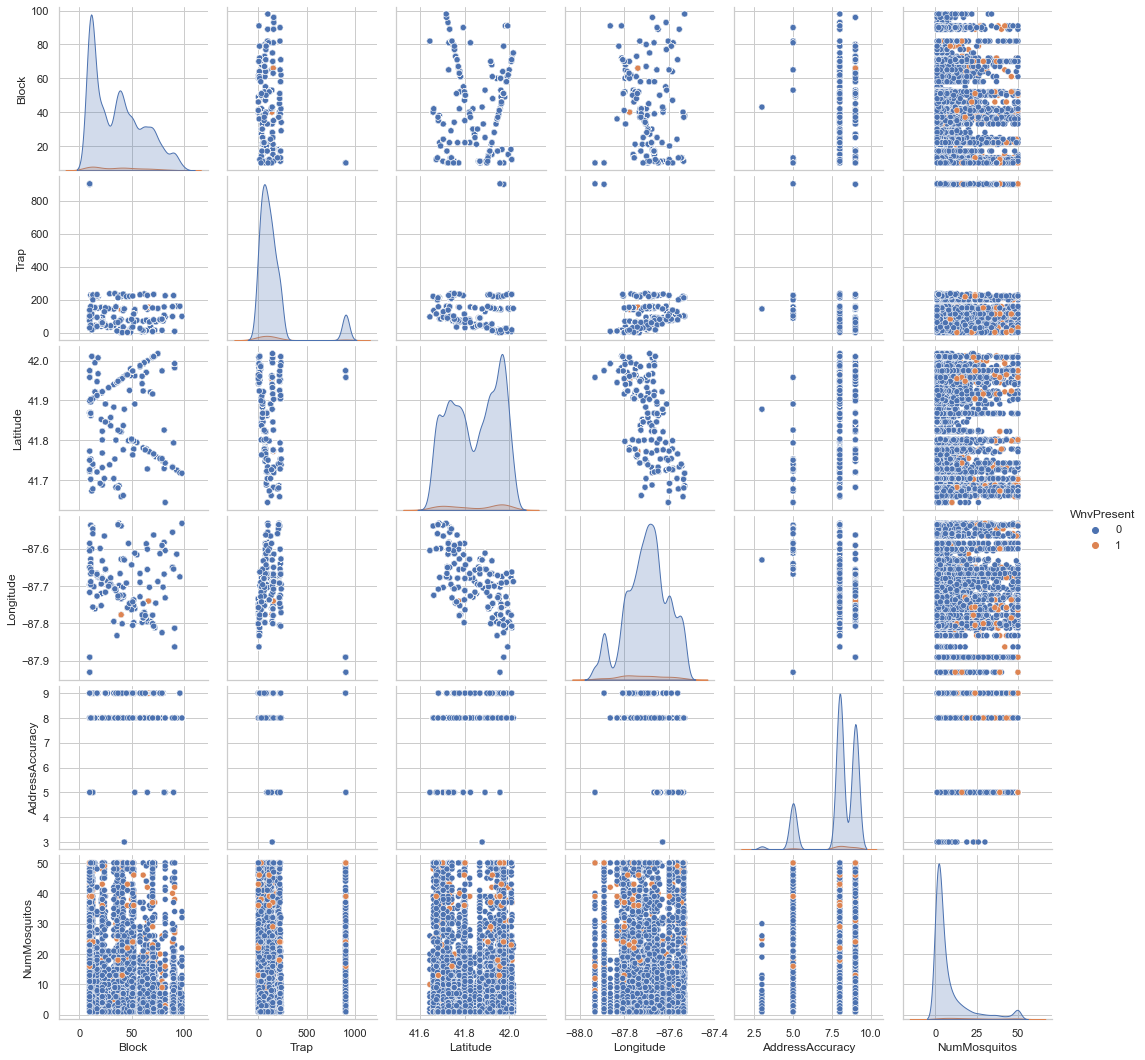

In [31]:
# Выведем парную корреляцию и распределение числовых переменных в обучающей выборке.
# Видно, что большинство переменных являются категориальными, и только ширина и долгота могут быть названы числовыми.
# Видно, что распределение признака количества насекомых в выборке экспоненциальное и, вероятно 
# необходимо его предварительно логарифмировать.
sns.pairplot(train, hue = 'WnvPresent');

In [32]:
# Преобразуем переменную NumMosquitos
train['NumMosquitos'] = train['NumMosquitos'].apply(np.log1p)
test['NumMosquitos'] = test['NumMosquitos'].apply(np.log1p)

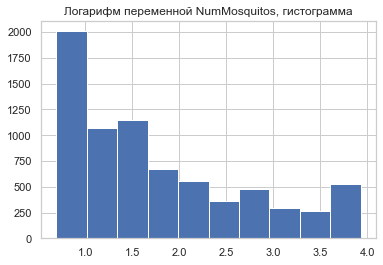

In [33]:
train.NumMosquitos.hist();
plt.title('Логарифм переменной NumMosquitos, гистограмма');

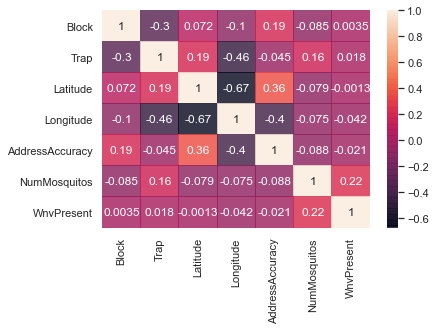

In [34]:
# Построим матрицу корреляции
sns.heatmap(train.corr(), alpha  = 0.8, annot=True);

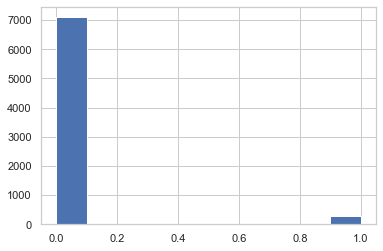

In [35]:
# Посмотрим на дисбаланс классов
train.WnvPresent.hist();

In [36]:
train.WnvPresent.value_counts(normalize=True)

0    0.962822
1    0.037178
Name: WnvPresent, dtype: float64

In [37]:
# Поскольку проблема заключается в предсказании редкого явления, этот дисбаланс является обычным явлением.
# (Как в прогнозировании мошеннических действий или звонков)
# Для работы с этим набором данных необходимо использовать правильные метрики качества и, возможно, применять
# методы oversampling

## Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [38]:
# Напишем функцию подготовки данных


def prepare_data(data,
                 addressMap,
                 speciesMap,
                 leAddress,
                 leSpecies,
                 oversamplig=False):

    # разобъём DateTiem на день, месяц (не будем создавать признака - год)
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    # удалим Date
    data.drop('Date', axis=1, inplace=True)

    # разметим месяца на сезоны
    # spring 2, summer 3, autumn 4, winter 1
    seasons = {
        3: 2,
        4: 2,
        5: 2,
        6: 3,
        7: 3,
        8: 3,
        9: 4,
        10: 4,
        11: 4,
        12: 1,
        1: 1,
        2: 1
    }

    data['Season'] = data.Month.map(seasons)

    # получим дополнительные переменный по частоте встречаемости
    data['SpeciesFreq'] = data.Species.map(speciesMap)
    data['AddressFreq'] = data.Address.map(addressMap)

    # закодируем категориальные переменные
    data['Species'] = leSpecies.transform(data.Species.values.tolist())
    data['Address'] = leAddress.transform(data.Address.values.tolist())

    # дополнительные признаки
    # квадрат разницы широты и долготы
    data['LatXLon'] = ((data.Latitude - data.Longitude)**0.5) % 11

    # Зависимоть количества комаров от сезона
    data['SeasonXNumMosq'] = data.Season * data.NumMosquitos

    # Балансировка выборки
    # oversampling - Synthetic Minority Oversampling Technique
    if oversamplig:
        features, target = SMOTE().fit_resample(
            data.drop('WnvPresent', axis=1), data.WnvPresent)
        data = pd.DataFrame(features,
                            columns=list(data.drop('WnvPresent', axis=1)))
        data['WnvPresent'] = target

    return data

In [39]:
addressMap = dict(Counter(train.Address.values.tolist()).most_common())
speciesMap = dict(Counter(train.Species.values.tolist()).most_common())

In [40]:
leAddress = preprocessing.LabelEncoder().fit(train.Address)
leSpecies = preprocessing.LabelEncoder().fit(train.Species)

In [41]:
train = prepare_data(train, addressMap, speciesMap, leAddress, leSpecies, True)
test = prepare_data(test, addressMap, speciesMap, leAddress, leSpecies, False)

In [42]:
train.head()

,Address,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,Month,Day,Season,SpeciesFreq,AddressFreq,LatXLon,SeasonXNumMosq,WnvPresent
0,29,1,41,2,41.954690,-87.800991,9,0.693147,5,29,2,3394,121,0.391035,1.386294,0
1,29,2,41,2,41.954690,-87.800991,9,0.693147,5,29,2,1896,121,0.391035,1.386294,0
2,64,2,62,7,41.994991,-87.769279,9,0.693147,5,29,2,1896,1876,0.391412,1.386294,0
3,64,1,79,15,41.974089,-87.824812,8,0.693147,5,29,2,3394,1876,0.392932,1.386294,0
4,64,2,79,15,41.974089,-87.824812,8,1.609438,5,29,2,1896,1876,0.392932,3.218876,0


In [43]:
test.head()

,Address,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Month,Day,Season,SpeciesFreq,AddressFreq,LatXLon,SeasonXNumMosq
8114,29,2,41,2,41.954690,-87.800991,9,2.995732,0,6,7,3,1896,121,0.391035,8.987197
8115,2,2,11,48,41.867108,-87.654224,8,1.098612,0,6,7,3,1896,114,0.380744,3.295837
8116,12,2,22,54,41.921965,-87.632085,8,0.693147,0,6,7,3,1896,112,0.382181,2.079442
8117,10,2,17,94,41.720848,-87.666014,9,1.609438,0,6,7,3,1896,88,0.374835,4.828314
8118,57,1,89,159,41.732984,-87.649642,8,1.609438,0,6,7,3,3394,75,0.374648,4.828314


Пока мы не будем проводить масштабирование данных, потому что все переменные в основном категориальные, и планируется использовать методы машинного обучения, которые работают с категориальными переменными.

## Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. 

<AxesSubplot:>

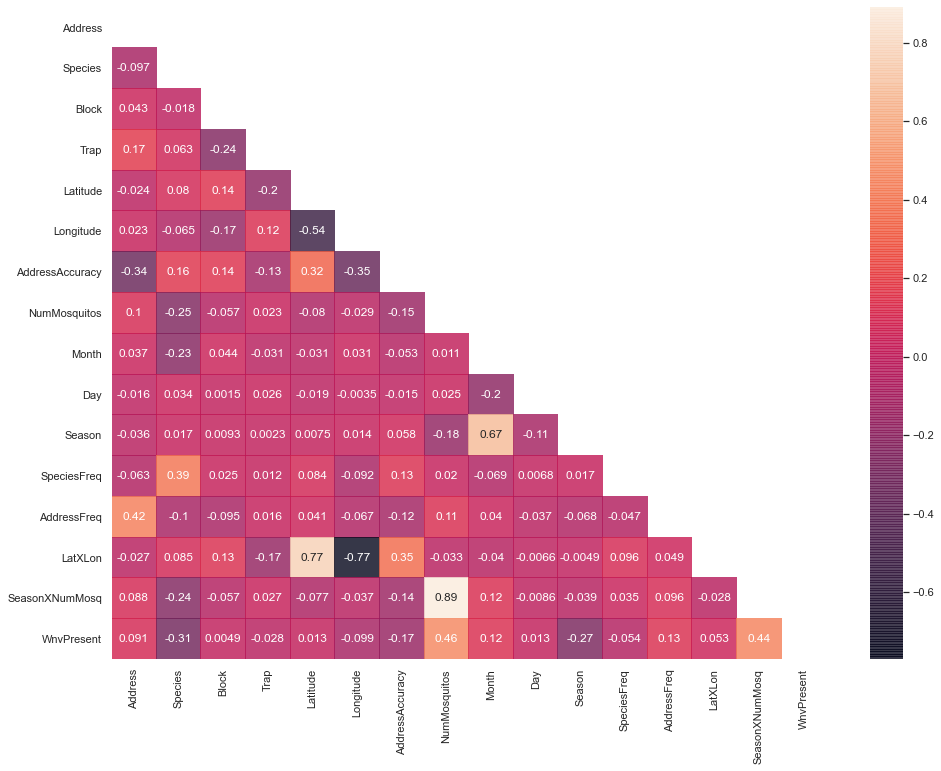

In [44]:
# Построим матрицу корреляции по методу Kendall, более подходящего для категориальных переменных
plt.figure(figsize=(16, 12))

corr = train.corr(method='kendall')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, alpha=0.8, annot=True)

Исходя из полученной корреляционной матрицы, можно сделать вывод, что наиболее коррелирующими признаками с целевой переменной являются признаки сезона и количество насекомых, протестированных на месте.

Не радует тот факт, что количество насекомых не только сильно коррелирует с целевой переменной, но и изменяется положительно, что может означать, что в ходе исследования была допущена ошибка, и что шанс обнаружения вируса в образце в конкретном месте больше зависит не от места ( что необходимо изучить), а от количества протестированных насекомых.

Тем не менее, данные подходят для дальнейшего анализа с помощью __нелинейных методов машинного обучения__.

## Выбор метрик для последующей оценки качества моделей. 

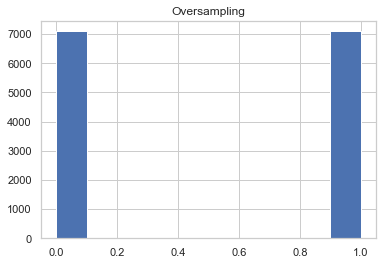

In [45]:
# распределение целевой переменной после балансировки методом oversampling
train.WnvPresent.hist();
plt.title('Oversampling');

Для оценки качества бинарной классификации на несбалансированной выборке стоит использовать метрики полноты, специфичности и их среднее гармоническое:

#### Специфичность (*precision*):

Отвечает на вопрос, сколько ресурсов было потрачено:

$precision = \frac{TP}{TP+FP}$


#### Полнота (*recall*):

Отвечает на вопрос, сколько объектов было пропущено:

$recall = \frac{TP}{TP+FN}$


#### Гармоническое среднее полноты и специфичности $F_1$-мера

Среднее между затраченными ресурсами и пропущенными объектами:

$F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$

----

Тем не менее, поскольку обучающая выборка была сбалансирована методом *oversampling*, для наглядности стоит включить в набор метрик и обычную метрику точности.

Более того, исследователи, собравшие этот набор данных, предложили использовать метрику ROC-AUC, которая показывает, насколько хорошо классы разделяются друг от друга при предсказании.

Поэтому в окончательном сравнении результатов будут применяться метрики F1 и ROC-AUC.

In [99]:
# Таким образом, метрики:
scoring_names = ['Точность', 'Специфичность', 'Полнота', 'F1', 'ROC-AUC']
scoring = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]

## Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.

Для решения задачи классификации будем использовать следующие методы машинного обучения:

  -  Дерево решений
  -  Лес решающих деревьев
  - Бустинг над решающими деревьями
  - Мета алгоритм стекинга с логистической регрессией, на лесе решений
  - Мета алгоритм стекинга с логистической регрессией, на бустинге над решающими деревьями
  
Приведенные выше методы были выбраны потому, что дерево решений, лежащее в основе этих подходов, хорошо работает с категориальными переменными и составляет основу многих ансамблевых методов.

## Формирование обучающей и тестовой выборок на основе исходного набора данных.

Этот пункт был выполнен выше во время подготовки данных, поскольку данные прогнозируются во времени.

## Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

In [112]:
tree = DecisionTreeClassifier()

rf = RandomForestClassifier()

lgb = LGBMClassifier()

first = [('rf', RandomForestClassifier())]
second = LogisticRegression()
stack_rf_lr = StackingClassifier(estimators=first, final_estimator=second)

first = [('lgb', LGBMClassifier())]
second = LogisticRegression()
stack_lgb_lr = StackingClassifier(estimators=first, final_estimator=second)

methods = [
    'Дерево решений', 'Лес решающих деревьев',
    'Бустинг над решающими деревьями',
    'Мета алгоритм стекинга с логистической регрессией, на лесе решающих деревьев',
    'Мета алгоритм стекинга с логистической регрессией, на бустинге над решающими деревьями'
]

models = [tree, rf, lgb, stack_rf_lr, stack_lgb_lr]

In [113]:
def train_test(model, method, X_train, X_test, y_train, y_test):
    predicted = model.fit(X_train, y_train)

    result = {}
    for score, scoring_name in zip(scoring, scoring_names):
        if scoring_name != 'ROC-AUC':
            result[scoring_name] = [score(y_test, model.predict(X_test))]
        else:
            result[scoring_name] = [
                score(y_test,
                      model.predict_proba(X_test)[:, 1])
            ]

    result = pd.DataFrame.from_dict(result)
    plot_roc_curve(model, X_test, y_test)
    plt.title('ROC-кривая')
    plt.suptitle(method)
    plt.show()

    print(tabulate(result, headers='keys', tablefmt="psql"))
    print('\n\n\n')
    return result

In [114]:
X_train, X_test, y_train, y_test = train.drop('WnvPresent', axis=1), test.drop(
    'WnvPresent', axis=1), train.WnvPresent, test.WnvPresent

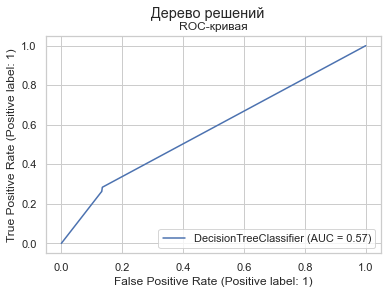

+----+------------+-----------------+-----------+---------+-----------+
|    |   Точность |   Специфичность |   Полнота |      F1 |   ROC-AUC |
|----+------------+-----------------+-----------+---------+-----------|
|  0 |   0.807576 |        0.177515 |  0.262009 | 0.21164 |   0.57345 |
+----+------------+-----------------+-----------+---------+-----------+






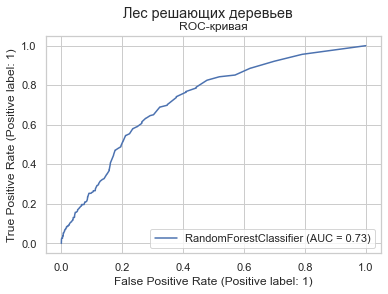

+----+------------+-----------------+-----------+------+-----------+
|    |   Точность |   Специфичность |   Полнота |   F1 |   ROC-AUC |
|----+------------+-----------------+-----------+------+-----------|
|  0 |   0.863969 |        0.245614 |  0.183406 | 0.21 |   0.72702 |
+----+------------+-----------------+-----------+------+-----------+






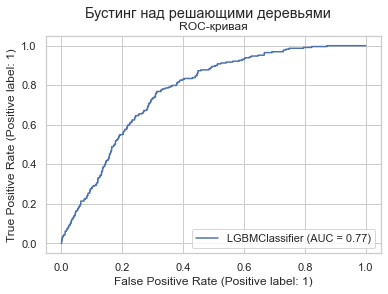

+----+------------+-----------------+-----------+----------+-----------+
|    |   Точность |   Специфичность |   Полнота |       F1 |   ROC-AUC |
|----+------------+-----------------+-----------+----------+-----------|
|  0 |   0.857512 |           0.245 |  0.213974 | 0.228438 |  0.770518 |
+----+------------+-----------------+-----------+----------+-----------+






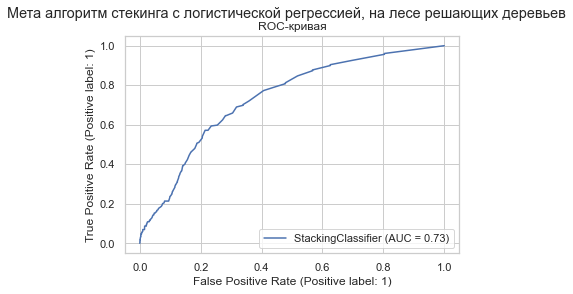

+----+------------+-----------------+-----------+----------+-----------+
|    |   Точность |   Специфичность |   Полнота |       F1 |   ROC-AUC |
|----+------------+-----------------+-----------+----------+-----------|
|  0 |    0.88248 |         0.27551 |  0.117904 | 0.165138 |  0.733115 |
+----+------------+-----------------+-----------+----------+-----------+






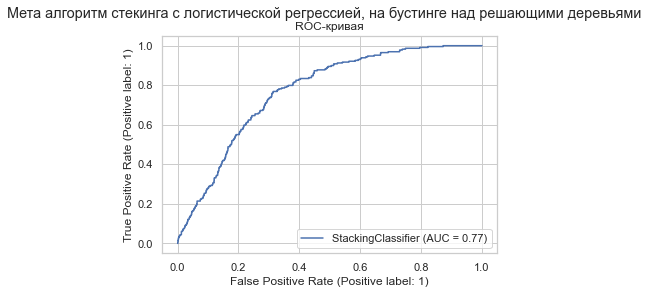

+----+------------+-----------------+-----------+----------+-----------+
|    |   Точность |   Специфичность |   Полнота |       F1 |   ROC-AUC |
|----+------------+-----------------+-----------+----------+-----------|
|  0 |   0.875161 |           0.256 |  0.139738 | 0.180791 |  0.770518 |
+----+------------+-----------------+-----------+----------+-----------+






In [115]:
DATA_1 = []
for model, method in zip(models, methods):
    DATA_1.append(train_test(model, method, X_train, X_test, y_train, y_test))

## Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.

In [85]:
parameters_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(3, 20, 3))
}

In [87]:
tree = GridSearchCV(DecisionTreeClassifier(),
                    parameters_tree,
                    verbose=1,
                    cv=3,
                    scoring='f1')
tree.fit(X_train, y_train)
tree.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9, 12, 15, 18]},
             scoring='f1', verbose=1)

In [90]:
tree.best_params_

{'criterion': 'entropy', 'max_depth': 15}

In [89]:
parameters_rf = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(3, 20, 3)),
    'n_estimators': list(range(100, 1000, 100))
}

rf = GridSearchCV(RandomForestClassifier(),
                  parameters_rf,
                  verbose=1,
                  cv=3,
                  scoring='f1')
rf.fit(X_train, y_train)
rf.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


RandomForestClassifier(max_depth=18, n_estimators=200)

In [91]:
rf.best_params_

{'criterion': 'gini', 'max_depth': 18, 'n_estimators': 200}

In [92]:
parameters_lgb = {
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': list(range(3, 20, 3)),
    'n_estimators': list(range(100, 1000, 100))
}

lgb = GridSearchCV(LGBMClassifier(),
                   parameters_lgb,
                   verbose=1,
                   cv=3,
                   scoring='f1')
lgb.fit(X_train, y_train)
lgb.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


LGBMClassifier(max_depth=6, n_estimators=900)

In [93]:
lgb.best_params_

{'boosting_type': 'gbdt', 'max_depth': 6, 'n_estimators': 900}

## Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.

In [116]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=15)

rf = RandomForestClassifier(criterion='gini', max_depth=18, n_estimators=200)

lgb = LGBMClassifier(boosting_type='gbdt', max_depth=6, n_estimators=900)

first = [('rf',
          RandomForestClassifier(criterion='gini',
                                 max_depth=18,
                                 n_estimators=200))]
second = LogisticRegression()
stack_rf_lr = StackingClassifier(estimators=first, final_estimator=second)

first = [('lgb',
          LGBMClassifier(boosting_type='gbdt', max_depth=6, n_estimators=900))]
second = LogisticRegression()
stack_lgb_lr = StackingClassifier(estimators=first, final_estimator=second)

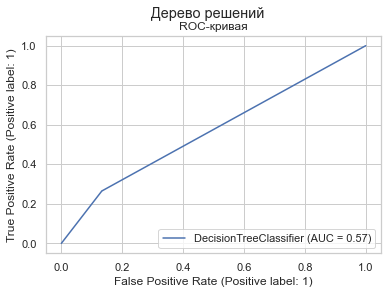

+----+------------+-----------------+-----------+---------+-----------+
|    |   Точность |   Специфичность |   Полнота |      F1 |   ROC-AUC |
|----+------------+-----------------+-----------+---------+-----------|
|  0 |   0.806715 |        0.178363 |  0.266376 | 0.21366 |   0.56598 |
+----+------------+-----------------+-----------+---------+-----------+






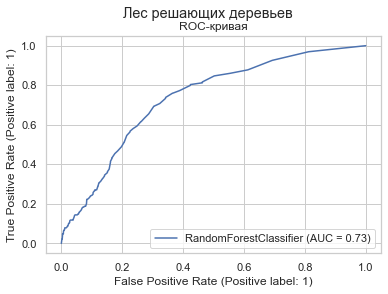

+----+------------+-----------------+-----------+----------+-----------+
|    |   Точность |   Специфичность |   Полнота |       F1 |   ROC-AUC |
|----+------------+-----------------+-----------+----------+-----------|
|  0 |   0.861817 |        0.222892 |  0.161572 | 0.187342 |  0.733781 |
+----+------------+-----------------+-----------+----------+-----------+






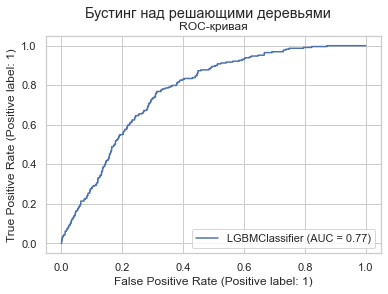

+----+------------+-----------------+-----------+----------+-----------+
|    |   Точность |   Специфичность |   Полнота |       F1 |   ROC-AUC |
|----+------------+-----------------+-----------+----------+-----------|
|  0 |   0.857512 |           0.245 |  0.213974 | 0.228438 |  0.770518 |
+----+------------+-----------------+-----------+----------+-----------+






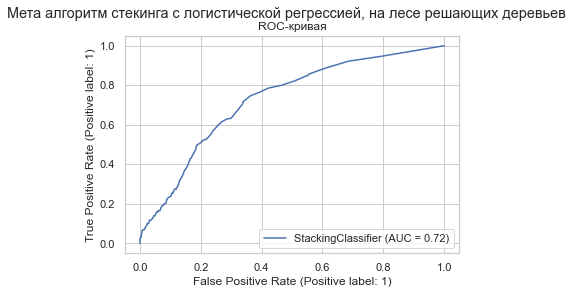

+----+------------+-----------------+-----------+----------+-----------+
|    |   Точность |   Специфичность |   Полнота |       F1 |   ROC-AUC |
|----+------------+-----------------+-----------+----------+-----------|
|  0 |   0.878175 |        0.254545 |  0.122271 | 0.165192 |   0.72495 |
+----+------------+-----------------+-----------+----------+-----------+






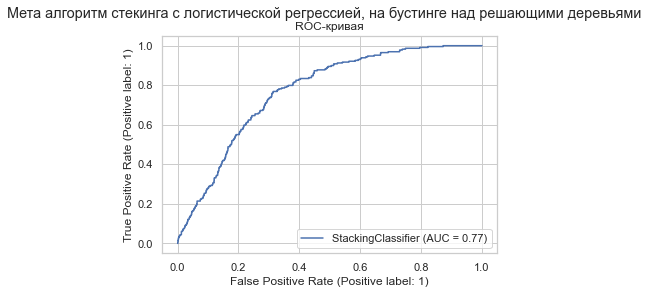

+----+------------+-----------------+-----------+----------+-----------+
|    |   Точность |   Специфичность |   Полнота |       F1 |   ROC-AUC |
|----+------------+-----------------+-----------+----------+-----------|
|  0 |   0.875161 |           0.256 |  0.139738 | 0.180791 |  0.770518 |
+----+------------+-----------------+-----------+----------+-----------+






In [117]:
DATA_2 = []
for model, method in zip(models, methods):
    DATA_2.append(train_test(model, method, X_train, X_test, y_train, y_test))

1.11  Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.

In [124]:
DATA_1 = reduce(lambda x, y: x.append(y), DATA_1)
DATA_1['Метод'] = methods
DATA_1['Тип'] = 'базовое решение'
DATA_1

,Точность,Специфичность,Полнота,F1,ROC-AUC,Метод,Тип
0,0.807576,0.177515,0.262009,0.211640,0.573450,Дерево решений,базовое решение
0,0.863969,0.245614,0.183406,0.210000,0.727020,Лес решающих деревьев,базовое решение
0,0.857512,0.245000,0.213974,0.228438,0.770518,Бустинг над решающими деревьями,базовое решение
0,0.882480,0.275510,0.117904,0.165138,0.733115,Мета алгоритм стекинга с логистической регресс...,базовое решение
0,0.875161,0.256000,0.139738,0.180791,0.770518,Мета алгоритм стекинга с логистической регресс...,базовое решение


In [125]:
DATA_2 = reduce(lambda x, y: x.append(y), DATA_2)
DATA_2['Метод'] = methods
DATA_2['Тип'] = 'оптимальные значения гиперпараметров'
DATA_2

,Точность,Специфичность,Полнота,F1,ROC-AUC,Метод,Тип
0,0.806715,0.178363,0.266376,0.213660,0.565980,Дерево решений,оптимальные значения гиперпараметров
0,0.861817,0.222892,0.161572,0.187342,0.733781,Лес решающих деревьев,оптимальные значения гиперпараметров
0,0.857512,0.245000,0.213974,0.228438,0.770518,Бустинг над решающими деревьями,оптимальные значения гиперпараметров
0,0.878175,0.254545,0.122271,0.165192,0.724950,Мета алгоритм стекинга с логистической регресс...,оптимальные значения гиперпараметров
0,0.875161,0.256000,0.139738,0.180791,0.770518,Мета алгоритм стекинга с логистической регресс...,оптимальные значения гиперпараметров


In [149]:
DATA = DATA_1.append(DATA_2)

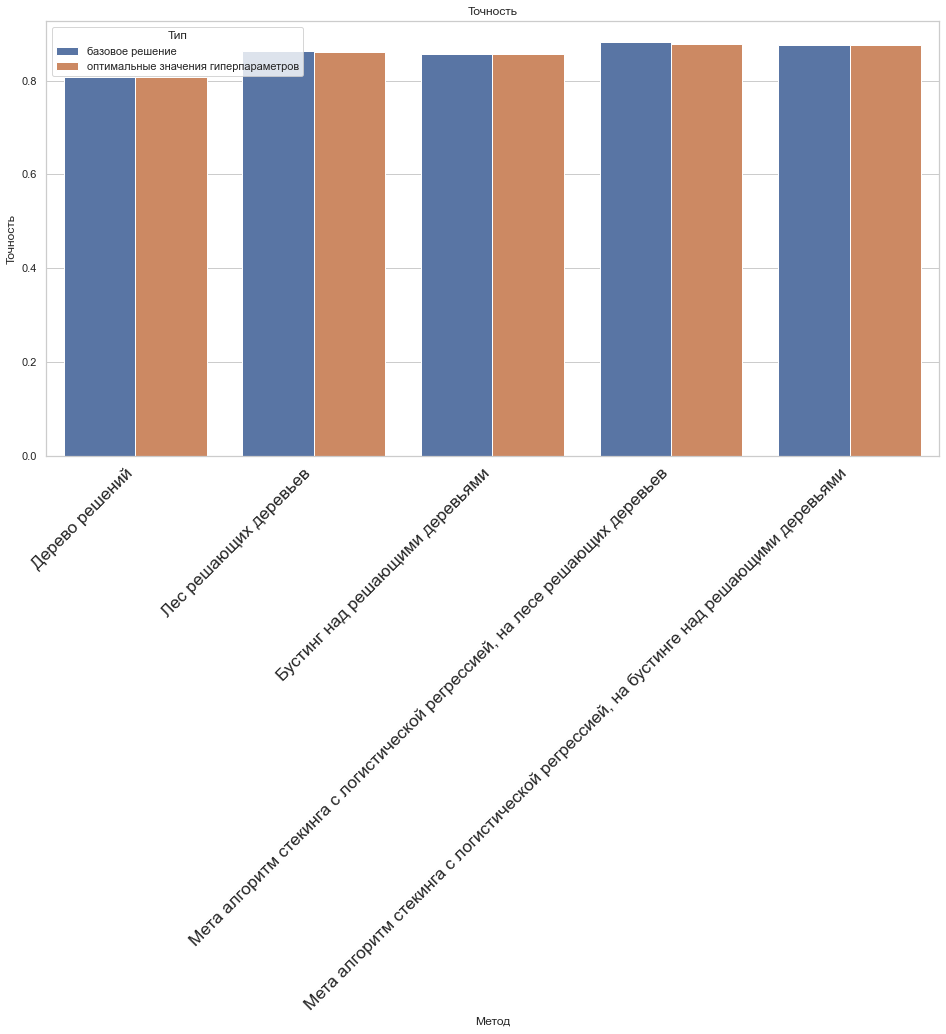

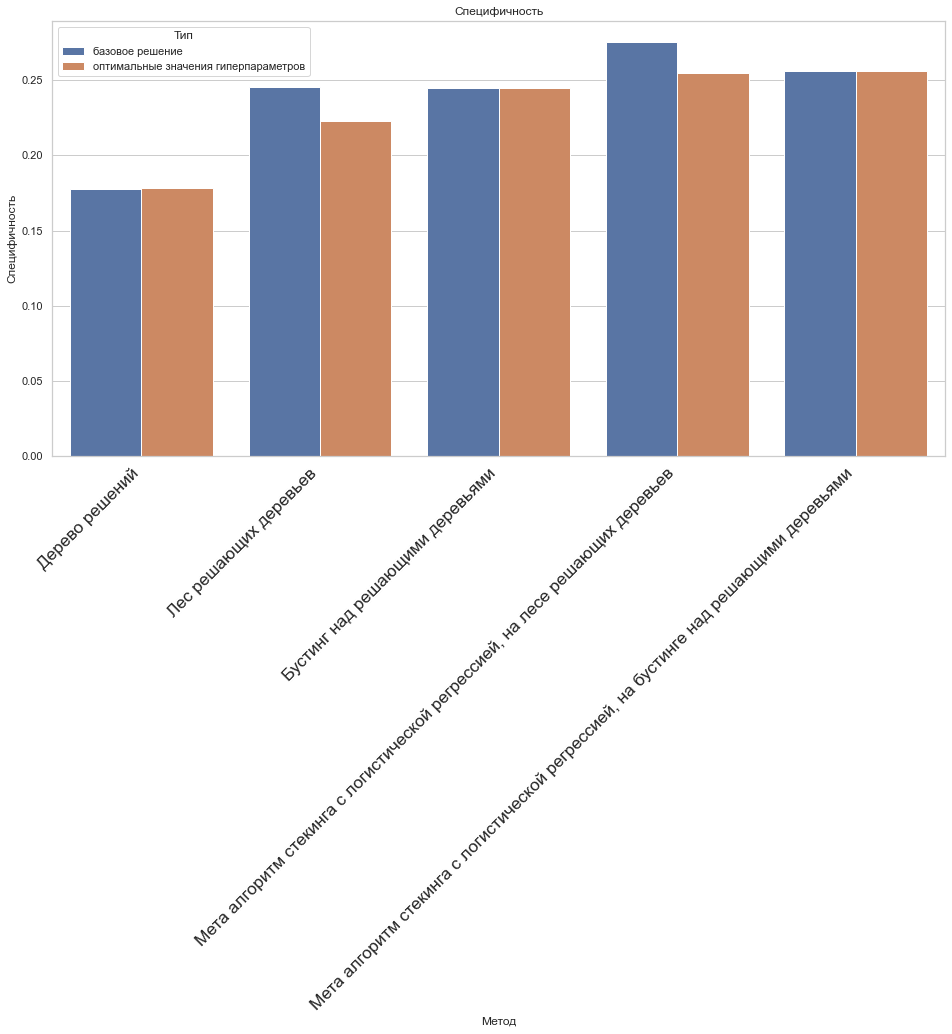

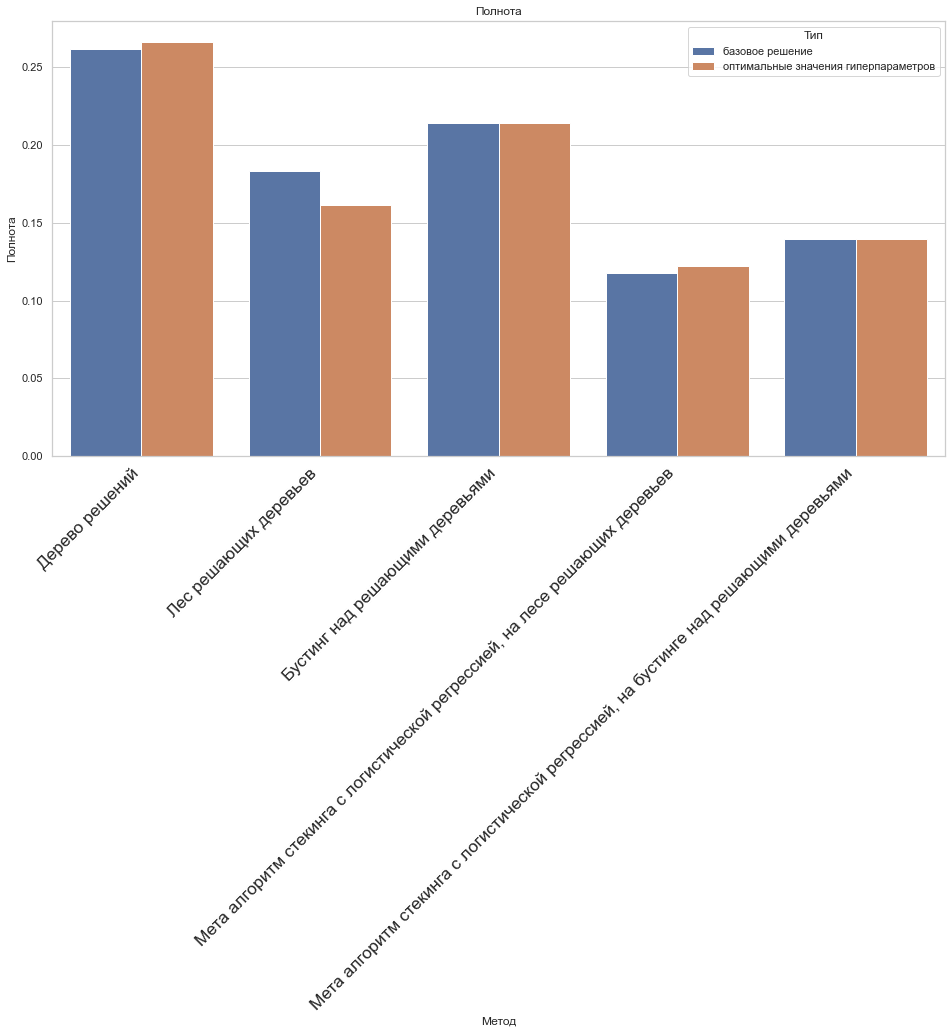

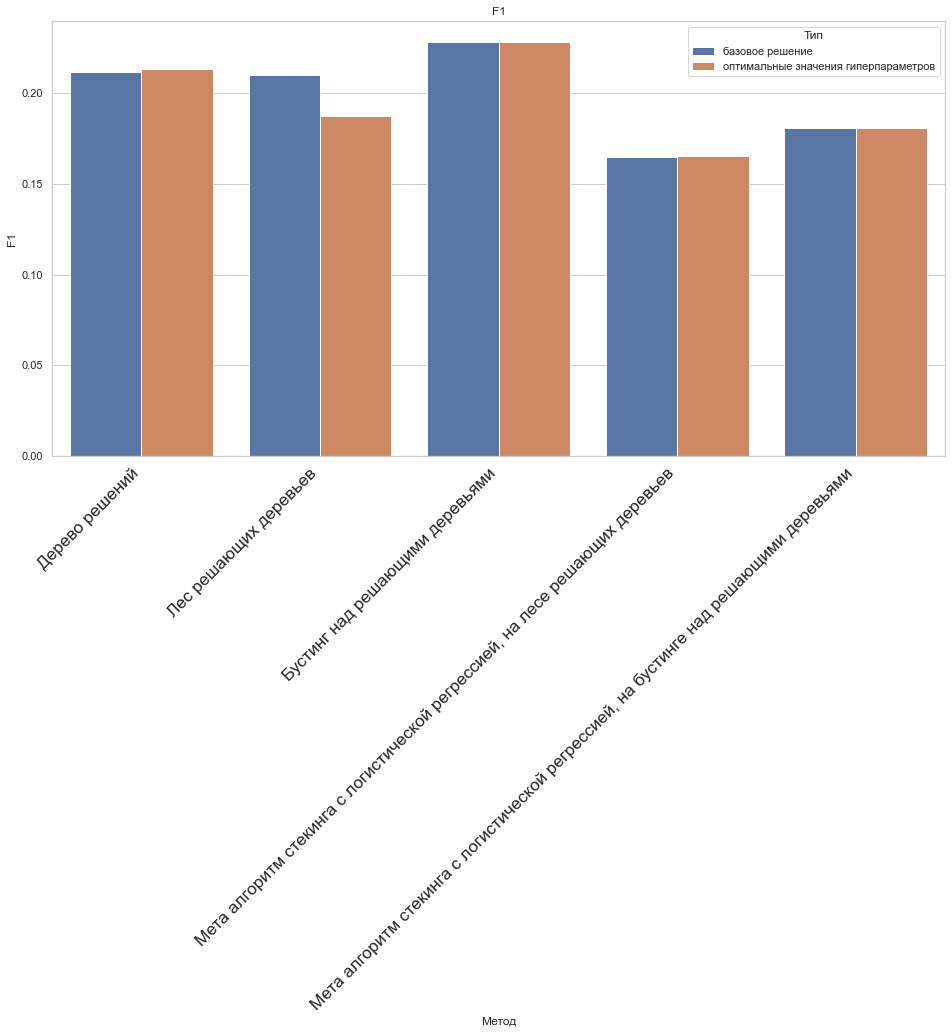

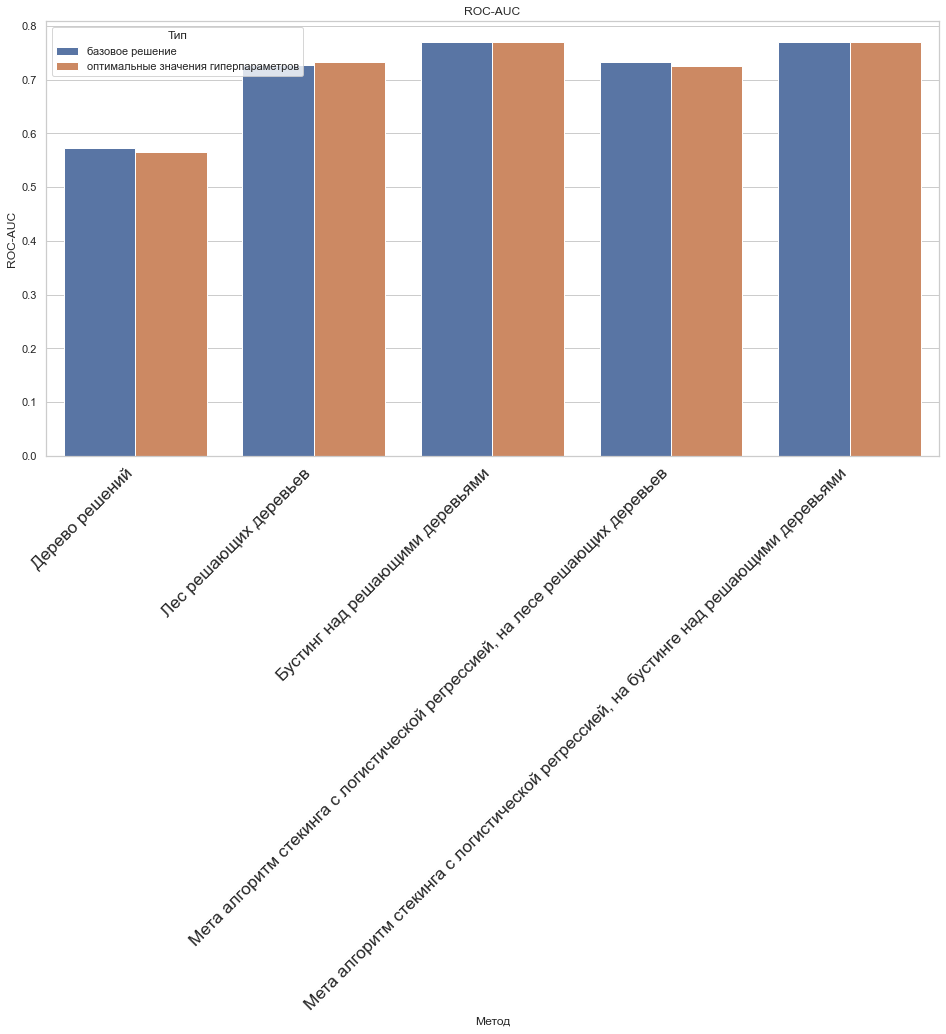

In [154]:
for score in scoring_names:
    plt.figure(figsize=(16, 8))
    sns.barplot(x="Метод", y=score, hue="Тип", data=DATA)
    plt.xticks(rotation=45,
               horizontalalignment='right',
               fontweight='light',
               fontsize='x-large')
    plt.title(score)
    plt.tight_layout()
    plt.show()

В ходе решения задачи классификации были выбраны и протестированы пять алгоритмов машинного обучения, подходящих для классификации данных с большим количеством категориальных переменных. Оптимальные гиперпараметры подбирались с помощью метода поиска по сетке с перекрестной валидацией.

Результаты позволили сделать вывод, что наилучшим способом решения задачи является алгоритм - бустинга над решающими деревьями, реализованный в библиотеке LightGBM. Тем не менее, наиболее интерпретируемые результаты при относительно высоком значении метрики полноты на тестовой выборке - могут быть получены методом классификации с помощью дерева решений. Поскольку задача носит прикладной характер, интерпретируемость дерева решений может помочь исследователям в мониторинге распространения вируса


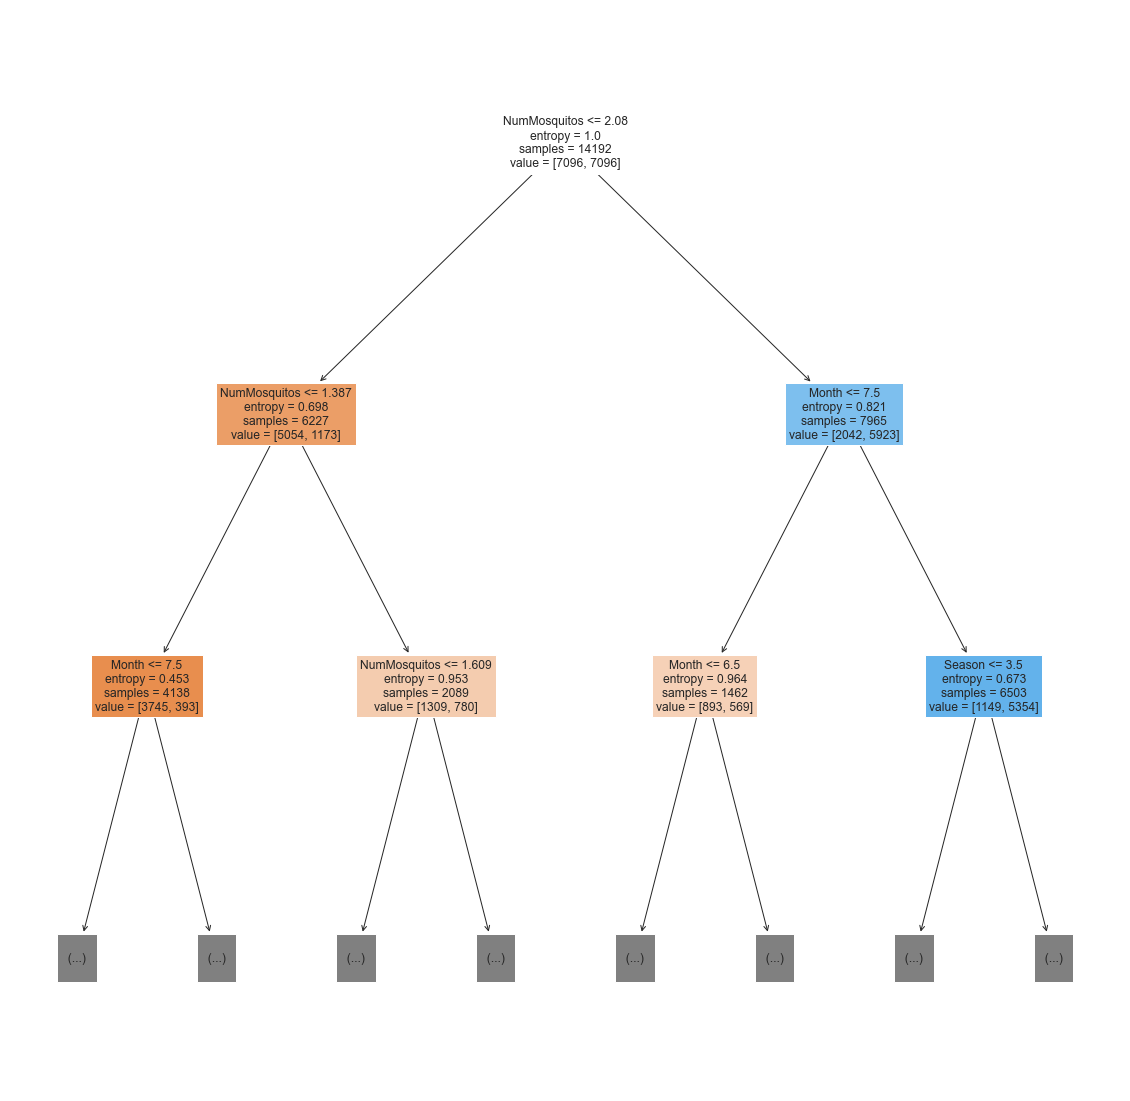

In [162]:
# визуализируем оптимальное дерево решений
plt.figure(figsize=(20, 20))
tree.fit(X_train, y_train)
plot_tree(tree, max_depth=2, feature_names=list(X_train), filled=True)